In [12]:
def my_axis_options(ax):
    ax.loglog()
    ax.set_xlabel("Physical Error Rate")
    ax.set_ylabel("Logical Error Rate per round")
    ax.legend()
    ax.grid()
    ax.grid(True, which = 'minor')
    # fig.set_dpi(120)  # Show it bigger
    ax.set_ylim(#1.7e-8
    None, 3.5e-1)
    ax.set_xlim(1e-4, 1e-2)
    ax.legend(*zip(*sorted(zip(*ax.get_legend_handles_labels()), key=lambda x: tuple(map(int, re.findall(r'\d+', x[1]))))))  # sort legend labels by number of qubits
    # ax.figure.savefig(f"../plots/tham_modules_noise.png", dpi = 300, bbox_inches = "tight")
    ax.figure.savefig(f"../plots/scrap.png", dpi = 300, bbox_inches = "tight")

/tmp/ipykernel_49891/2191008835.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
/tmp/ipykernel_49891/2191008835.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(*zip(*sorted(zip(*ax.get_legend_handles_labels()), key=lambda x: tuple(map(int, re.findall(r'\d+', x[1]))))))  # sort legend labels by number of qubits


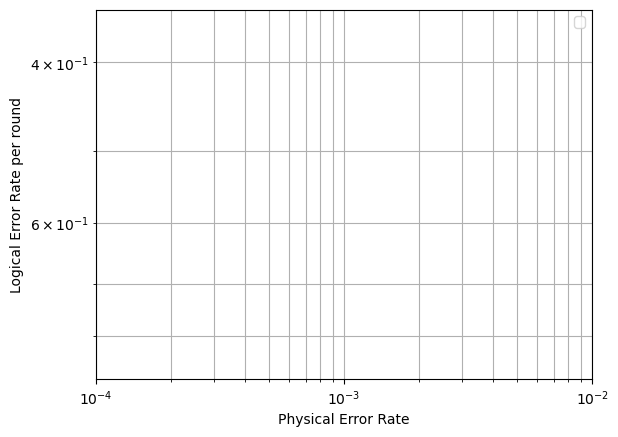

In [14]:
import matplotlib.pyplot as plt
import sinter 
import re


# collected_stats = sinter.stats_from_csv_files(f'../collected_stats/collected_stats_tham_modules.csv') #_min_sum_0.625_serial_osd_cs_9.csv')
collected_stats = sinter.stats_from_csv_files(f'../collected_stats/tham_modules_noise_long_chain_BPOSD_settings.csv', f'../collected_stats/288_12_18_tham_modules_noise_long_chain_BPOSD_settings.csv')
# collected_stats = sinter.stats_from_csv_files(f'../collected_stats/tham_modules_noise_long_chain_BPOSD_settings_but_with_osd9.csv')

# collected_stats = sinter.stats_from_csv_files(f'../collected_stats/copy_of_collected_stats_tham_modules_incl_opp_detectors.csv', f'../collected_stats/copy_of_mars_collected_stats_tham_modules_incl_opp_detectors.csv')

fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=collected_stats,
    x_func=lambda stats: stats.json_metadata['p'],
    group_func=lambda stats: stats.json_metadata['nkd'],
    failure_units_per_shot_func = lambda stats: stats.json_metadata['r'], # set as num_rounds ('r') failure units to find pL per round
    filter_func=lambda s: 
        # s.json_metadata['T2'] == 10 and 
        # s.json_metadata['pause'] == 0 and 
        s.json_metadata['p'] >= 0.5e-3 and 
        s.json_metadata['b'] == 'X' ,
        # and '288' not in s.json_metadata['nkd'],
    plot_args_func = lambda index, curve_id: {
        'color': 'green' if '108' in curve_id else 'red' if '144' in curve_id else 'orange' if '90' in curve_id else 'blue' if '72' in curve_id else 'black',
        'marker': 'o'
}


)

my_axis_options(ax)

In [15]:
import sinter

for stat in collected_stats:
    if stat.json_metadata['p'] == 0.0005:
        nkd = stat.json_metadata['nkd'].strip("[]").split("_")
        k = int(nkd[1])
        print(k)


12
8
8
12
